<a href="https://colab.research.google.com/github/JAEHYEONG8121/Pytorch-Tutorial/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ResNet

- When we training deep neural networks the accuracy should always go down as we increase the depth of the network.

- Which theroy holds true but since it can learn more complex features of mapping.

- But in practice it actually becomes worse after some layers. This is the problem that ResNet architecture wants to solve.


***


**Skip Connection**

- Skip connection is core idea of ResNet.
- When we increase the depth of neural network,the gradients become too small during backpropagation.
- So it can't propagate through previous layers.
- We call this problem "Vanishing Gradient".
- ResNet solve this problem by using Skip
Connection.

**How Skip Connection Works**

- Residual Block
  - In ResNet, each residual block consist of two or more conv layers, with a skip connection that adds the input directly to the output of these layers.
  - Mathematically, the output y of a residual block can be expressed as:
  y = F(x) + x

  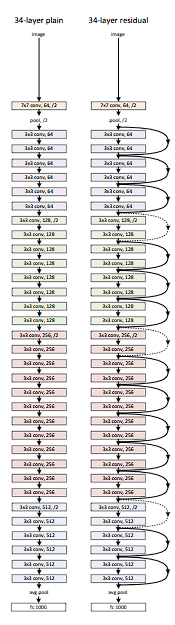

***

**ResNet Architecture**

  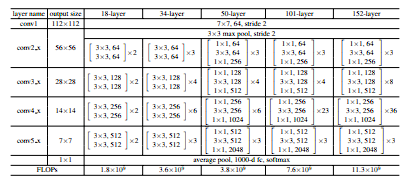



In [1]:
# Imports
import torch
import torch.nn as nn

In [3]:
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(block, self).__init__()
    self.expansion = 4
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x

In [10]:
class ResNet(nn.Module):# layers -> how many time we want to use block, 50-layer : [3, 4, 6, 3]
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet layers
    self.layer1 = self.make_layer(block, layers[0], out_channels=64, stride=1)
    self.layer2 = self.make_layer(block, layers[1], out_channels=128, stride=2)
    self.layer3 = self.make_layer(block, layers[2], out_channels = 256, stride=2)
    self.layer4 = self.make_layer(block, layers[3], out_channels=512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*4, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x


  def make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride != 1 or self.in_channels != out_channels * 4:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                    stride=stride),
                                          nn.BatchNorm2d(out_channels*4))

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels = out_channels*4

    for i in range(num_residual_blocks -1):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

In [12]:
def ResNet50(img_channels=3, num_classes=1000):
  return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

def ResNet101(img_channels=3, num_classes=1000):
  return ResNet(block, [3, 4, 23, 3], img_channels, num_classes)

def ResNet152(img_channels=3, num_classes=1000):
  return ResNet(block, [3, 8, 36, 3], img_channels, num_classes)

def test():
  net = ResNet50()
  x = torch.randn(2, 3, 224, 224)
  y = net(x)
  print(y.shape)

In [13]:
test()

torch.Size([2, 1000])
